# Master notebook

## Imports

In [1]:
import xarray as xr
import glob
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

from google.cloud import storage
import gcsfs
import zarr

import xskillscore as xs
import pandas as pd

import os

import re

## SYNOP processing

In [188]:
# # Define a function to create the file pattern for the desired time points
# def generate_file_patterns(base_path, start_date, end_date, hours):
#     file_patterns = []
#     current_date = start_date
#     while current_date <= end_date:
#         for hour in hours:
#             # Generate the pattern for the files at 00 minutes
#             pattern = f"{base_path}/{current_date.year}/{current_date.month:02d}/{current_date.day:02d}/{hour:02d}/KMDS__OPER_P___10M_OBS_L2_{current_date.year}{current_date.month:02d}{current_date.day:02d}{hour:02d}00.nc"
#             file_patterns.append(pattern)
#         # Move to the next day
#         current_date += datetime.timedelta(days=1)
#     return file_patterns

# # Define the base path and desired time points
# base_path = "/net/shared/student-projects/koenr/knmi_synop"
# start_date = datetime.date(2022, 1, 12)  # Start from January 12th
# end_date = datetime.date(2022, 12, 31)   # Until the end of the year
# hours = [0, 6, 12, 18]  # Every 6 hours

# # Generate the list of file patterns
# file_patterns = generate_file_patterns(base_path, start_date, end_date, hours)

# # Initialize an empty list to store the matching files
# file_list = []

# # Use glob to find all matching files
# for pattern in file_patterns:
#     file_list.extend(glob.glob(pattern))

# # Sort the file list to ensure proper ordering
# file_list = sorted(file_list)

# # Open and combine the datasets
# ds = xr.open_mfdataset(file_list, combine='by_coords')

# # Write to file
# ds.to_netcdf('/home/koenr/thesis_code/Graphcast/SYNOP_2022.nc')

# ds

# This block takes 40 minutes to run

#### Plotting the stations and graphcast/HRES grid

56
53
50
50


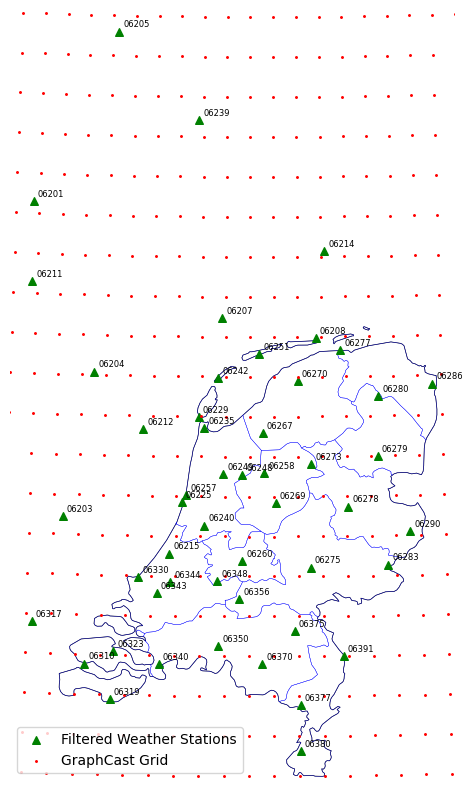

In [2]:
synop = xr.open_dataset('/home/koenr/thesis_code/SYNOP_2022.nc')

# Assuming synop` is your dataset containing lat/lon information
station_lats =synop['lat'].isel(time=100).values  # Assuming time doesn't affect lat/lon
station_lons =synop['lon'].isel(time=100).values  # Select first time step to ensure scalars
station_names =synop['station'].values  # Station identifiers

print(len(station_lats))

# Remove any stations where lat or lon is NaN
valid_mask = ~np.isnan(station_lats) & ~np.isnan(station_lons)
station_lats = station_lats[valid_mask]
station_lons = station_lons[valid_mask]
station_names = station_names[valid_mask]

print(len(station_lats))

# Define the latitude and longitude boundaries
lat_min = 40  # Southern boundary
lat_max = 70  # Northern boundary
lon_min = -5   # Western boundary (includes North Sea offshore locations)
lon_max = 16   # Eastern boundary

# Filter the stations based on the lat/lon boundaries
valid_bounds_mask = (
    (station_lats >= lat_min) & (station_lats <= lat_max) &
    (station_lons >= lon_min) & (station_lons <= lon_max)
)
station_lats = station_lats[valid_bounds_mask]
station_lons = station_lons[valid_bounds_mask]
station_names = station_names[valid_bounds_mask]

print(len(station_lats))

# Create a GeoDataFrame with the filtered station locations
gdf_stations = gpd.GeoDataFrame(
    {'Station': station_names},
    geometry=[Point(lon, lat) for lon, lat in zip(station_lons, station_lats)],
    crs="EPSG:4326"  # Initial projection is WGS84
)

print(len(gdf_stations))

# Load the shapefile for country boundaries and reproject to EPSG:28992
world = gpd.read_file("/home/koenr/thesis_code/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
netherlands = world[(world.SOVEREIGNT == "Netherlands") & (world.CONTINENT == "Europe")]
netherlands = netherlands.to_crs(epsg=28992)

# Load the shapefile for provinces and reproject to EPSG:28992
provinces = gpd.read_file("/home/koenr/thesis_code/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
provinces = provinces.to_crs(epsg=28992)

# Filter for the Netherlands using the 'ADM1_CODE' that starts with 'NLD'
netherlands_provinces = provinces[
    provinces['adm1_code'].str.startswith('NLD') &
    (provinces['geometry'].centroid.y > 300000) &  # Adjusted latitude filter for EPSG:28992
    (provinces['geometry'].centroid.y < 620000) &  # Upper latitude bound
    (provinces['geometry'].centroid.x > -100000) &  # Adjusted longitude filter for EPSG:28992
    (provinces['geometry'].centroid.x < 300000)  # Upper longitude bound
]

# Create grid points at 0.25 degree intervals in WGS84
lat_points = np.arange(lat_min, lat_max, 0.25)
lon_points = np.arange(lon_min, lon_max, 0.25)
grid_points = np.array(np.meshgrid(lon_points, lat_points)).T.reshape(-1, 2)

# Create a GeoDataFrame for the grid points in WGS84
gdf_grid = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in grid_points],
    crs="EPSG:4326"  # WGS84 projection
)

# Reproject the grid points to the Netherlands-specific projection (EPSG:28992)
gdf_grid = gdf_grid.to_crs(epsg=28992)

# Reproject the filtered stations to the Netherlands-specific projection (EPSG:28992)
gdf_stations = gdf_stations.to_crs(epsg=28992)

# Plot the Netherlands with province boundaries
fig, ax = plt.subplots(figsize=(8, 10))

# Plot the Netherlands country boundary
netherlands.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Plot the Netherlands provinces boundaries
netherlands_provinces.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.25)

# Plot the filtered weather station locations
gdf_stations.plot(ax=ax, color='green', marker='^', markersize=30, label='Filtered Weather Stations')

# Plot the grid points
gdf_grid.plot(ax=ax, color='red', marker='.', markersize=5, label='GraphCast Grid')

# Annotate the weather stations (optional)
for idx, row in gdf_stations.iterrows():
    ax.annotate(row["Station"], xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=6)

# Set limits based on the exact extent of the Netherlands provinces, with some padding
padding = 15000  # Meter padding around the extents (since EPSG:28992 is in meters)
bounds = gdf_stations.total_bounds
ax.set_xlim(bounds[0] - padding, bounds[2] + padding)
ax.set_ylim(bounds[1] - padding - 5000, bounds[3] + padding)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.legend()
# plt.savefig('Filtered_SYNOP_stations_with_grid_offshore.png')
plt.show()

### SYNOP processing

In [49]:
# Function to convert wind speed and direction into u and v components
def wind_components(speed, direction):
    """
    Convert wind speed and direction into u and v components.
    speed: Wind speed (m/s)
    direction: Wind direction (degrees)
    Returns: u, v components of the wind (m/s)
    """
    rad = np.deg2rad(direction)
    u = speed * np.sin(rad) * -1
    v = speed * np.cos(rad) * -1
    return u, v

# Extract and rename variables
ds_renamed = synop.rename({
    'ta': '2m_temperature_synop',                        # 2m temperature
    'pp': 'mean_sea_level_pressure_synop',               # Mean sea level pressure
    'ff': 'wind_speed_synop',                            # 10m wind speed, to be converted
    'dd': 'wind_direction_synop',                        # 10m wind direction, to be converted
    'R6H': 'total_precipitation_6hr_synop',              # Rainfall in last 6 Hours
    # Add other variable mappings if necessary
})

# Calculate wind components from speed and direction
u_component, v_component = wind_components(ds_renamed['wind_speed_synop'], ds_renamed['wind_direction_synop'])

# Create DataArray objects for u and v components with appropriate coordinates and dimensions
u_dataarray = xr.DataArray(
    u_component,
    coords={'station': ds_renamed['station'], 'time': ds_renamed['time']},
    dims=['station', 'time'],
    name='10m_u_component_of_wind_synop'
)

v_dataarray = xr.DataArray(
    v_component,
    coords={'station': ds_renamed['station'], 'time': ds_renamed['time']},
    dims=['station', 'time'],
    name='10m_v_component_of_wind_synop'
)

# Add the wind components to the dataset
ds_renamed['10m_u_component_of_wind_synop'] = u_dataarray
ds_renamed['10m_v_component_of_wind_synop'] = v_dataarray

# Drop the original wind speed and direction since they're now represented as u and v components
ds_renamed = ds_renamed.drop_vars(['wind_speed_synop', 'wind_direction_synop'])

# Define latitude and longitude boundaries for mainland Netherlands and offshore North Sea
lat_min = 45  # Southern boundary
lat_max = 60  # Northern boundary
lon_min = 1   # Western boundary (includes North Sea offshore locations)
lon_max = 9   # Eastern boundary

# Filter the dataset based on the latitude and longitude boundaries
ds_filtered = ds_renamed.where(
    (ds_renamed['lat'] >= lat_min) &
    (ds_renamed['lat'] <= lat_max) &
    (ds_renamed['lon'] >= lon_min) &
    (ds_renamed['lon'] <= lon_max),
    drop=True
)

# Assuming `ds_filtered` is your dataset containing lat/lon information
# Select latitude and longitude at the first timestep
station_lats = ds_filtered['lat'].isel(time=0).values  # Select first timestep
station_lons = ds_filtered['lon'].isel(time=0).values  # Select first timestep
station_names = ds_filtered['station'].values  # Station identifiers

# Print the number of stations before filtering
print(f"Number of stations before filtering: {len(station_lats)}")

# Create a mask for valid stations (where lat and lon are not NaN)
valid_mask = ~np.isnan(station_lats) & ~np.isnan(station_lons)

# Filter stations based on the valid mask
station_lats = station_lats[valid_mask]
station_lons = station_lons[valid_mask]
station_names = station_names[valid_mask]

# Apply the valid mask to the dataset to drop stations with NaN lat/lon
ds_filtered = ds_filtered.sel(station=valid_mask)

# Print the number of stations after filtering
print(f"Number of stations after filtering: {len(station_lats)}")

# Keep only the specified variables
synop = ds_filtered[[  'stationname',
                            'height',
                            'lat',
                            'lon',
                            '2m_temperature_synop', 
                            'mean_sea_level_pressure_synop', 
                            '10m_u_component_of_wind_synop', 
                            '10m_v_component_of_wind_synop', 
                            'total_precipitation_6hr_synop']]

# Display the resulting dataset
synop



Number of stations before filtering: 53
Number of stations after filtering: 50


<xarray.Dataset> Size: 5MB
Dimensions:                        (time: 1362, station: 50)
Coordinates:
  * station                        (station) <U5 1kB '06201' '06203' ... '06391'
  * time                           (time) datetime64[ns] 11kB 2022-01-12 ... ...
Data variables:
    stationname                    (time, station) object 545kB 'D15-FA-1' .....
    height                         (time, station) float64 545kB 42.7 ... 19.5
    lat                            (time, station) float64 545kB 54.33 ... 51.5
    lon                            (time, station) float64 545kB 2.936 ... 6.196
    2m_temperature_synop           (station, time) float64 545kB 6.9 ... 15.4
    mean_sea_level_pressure_synop  (station, time) float64 545kB 1.034e+03 .....
    10m_u_component_of_wind_synop  (station, time) float64 545kB 6.063 ... 1.931
    10m_v_component_of_wind_synop  (station, time) float64 545kB 0.2859 ... 3...
    total_precipitation_6hr_synop  (station, time) float64 545kB nan nan ... 0.0
Attributes:
    featureType:  timeSeries
    Conventions:  CF-1.4
    title:        KMDS__OPER_P___10M_OBS_L2
    institution:  Royal Netherlands Meteorological Institute (KNMI)
    source:       Royal Netherlands Meteorological Institute (KNMI)
    history:      File created from KMDS ASCII file. 
    references:   http://data.knmi.nl
    comment:      Please note: no data has been found for the following varia...

## HRES Processing

### HRES loading and slicing

In [191]:
# # Accessing weatherbench data
# fs = gcsfs.GCSFileSystem(anon=True)  # Use anon=True for public data
# store = gcsfs.GCSMap(root='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr', gcs=fs, check=False)
# hres_for = xr.open_zarr(store, consolidated=True)

# # Renaming coordinates
# hres_for = hres_for.rename({'latitude': 'lat', 'longitude': 'lon'})

# # Slicing the data for the variables required
# hres_for = hres_for[[  
#                                 # 'geopotential_at_surface',
#                                 # 'land_sea_mask',                 
#                                 '2m_temperature',                
#                                 'mean_sea_level_pressure',       
#                                 '10m_v_component_of_wind',       
#                                 '10m_u_component_of_wind',       
#                                 'total_precipitation_6hr',       
#                                 # 'toa_incident_solar_radiation',  ----> to fix  
#                                 # 'temperature',                   
#                                 # 'geopotential',                  
#                                 # 'u_component_of_wind',           
#                                 # 'v_component_of_wind',          
#                                 # 'vertical_velocity',             
#                                 # 'specific_humidity'
#                                 ]]

# # Slice for 2022 and 4 days ahead
# hres_for = hres_for.sel(time='2022').isel(prediction_timedelta=range(1,17))  

# # Slice for 1 forecast per day
# hres_for = hres_for.sel(time=hres_for['time'].dt.hour == 0)

# # Slice for dates in SYNOP (2022-01-12 onwards)
# hres_for = hres_for.sel(time=slice( '2022-01-12','2022-12-31T00'))

# # Unit conversions to match synop
# hres_for['2m_temperature'] = hres_for['2m_temperature'] - 273.15
# hres_for['mean_sea_level_pressure'] = hres_for['mean_sea_level_pressure'] / 100

# # Rename variables to inlcude HRES specification
# hres_for = hres_for.rename_vars({
#     '2m_temperature': '2m_temperature_hres',                        # 2m temperature
#     'mean_sea_level_pressure': 'mean_sea_level_pressure_hres',               # Mean sea level pressure
#     '10m_v_component_of_wind': '10m_v_component_of_wind_hres',                            # 10m wind speed, to be converted
#     '10m_u_component_of_wind': '10m_u_component_of_wind_hres',                        # 10m wind direction, to be converted
#     'total_precipitation_6hr': 'total_precipitation_6hr_hres',              # Rainfall in last 6 Hours
#     # Add other variable mappings if necessary
# })

# # Verify the updated dataset
# hres_for

### HRES interpolating to station locations

In [192]:
# # Extract unique station location data
# station_locations = synop[['lat', 'lon']].isel(time=0).to_dataframe()

# # # Remove any rows with missing data
# # station_locations = station_locations.dropna()

# # Reset index to maintain station codes as part of the DataFrame
# station_locations.reset_index(inplace=True)

# # Interpolate the global dataset using lat/lon from station_locations
# hres_for_interp = hres_for.interp(lat=("station", station_locations['lat']),
#                                   lon=("station", station_locations['lon']))

# # # Assign station codes from synop as coordinates to the interpolated dataset
# hres_for_interp = hres_for_interp.assign_coords(station=("station", station_locations['station'].values))

# # # Add time dimension for merging
# hres_for_interp = hres_for_interp.assign_coords(valid_time=hres_for_interp['time'] + hres_for_interp['prediction_timedelta'])

# # Display the interpolated dataset
# hres_for_interp

### HRES analysis processing

In [54]:
# Accessing weatherbench data
fs = gcsfs.GCSFileSystem(anon=True)  # Use anon=True for public data
store = gcsfs.GCSMap(root='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr', gcs=fs, check=False)
hres_analysis = xr.open_zarr(store, consolidated=True)

# Renaming coordinates
hres_analysis = hres_analysis.rename({'latitude': 'lat', 'longitude': 'lon'})

# Slicing the data for the variables required
hres_analysis = hres_analysis[[  
                                # 'geopotential_at_surface',
                                # 'land_sea_mask',                 
                                '2m_temperature',                
                                'mean_sea_level_pressure',       
                                '10m_v_component_of_wind',       
                                '10m_u_component_of_wind',       
                                'total_precipitation_6hr',       
                                # 'toa_incident_solar_radiation',  ----> to fix  
                                # 'temperature',                   
                                # 'geopotential',                  
                                # 'u_component_of_wind',           
                                # 'v_component_of_wind',          
                                # 'vertical_velocity',             
                                # 'specific_humidity'
                                ]]

# # Slice for 1 forecast per day
# hres_analysis = hres_analysis.sel(time=hres_analysis['time'].dt.hour == 0)

# Slice for dates in SYNOP (2022-01-12 onwards)
hres_analysis = hres_analysis.sel(time=slice( '2022-01-12','2022-12-31T00'))

# Unit conversions to match synop
hres_analysis['2m_temperature'] = hres_analysis['2m_temperature'] - 273.15
hres_analysis['mean_sea_level_pressure'] = hres_analysis['mean_sea_level_pressure'] / 100

# Rename variables to inlcude HRES specification
hres_analysis = hres_analysis.rename_vars({
    '2m_temperature': '2m_temperature_analysis',                        # 2m temperature
    'mean_sea_level_pressure': 'mean_sea_level_pressure_analysis',               # Mean sea level pressure
    '10m_v_component_of_wind': '10m_v_component_of_wind_analysis',                            # 10m wind speed, to be converted
    '10m_u_component_of_wind': '10m_u_component_of_wind_analysis',                        # 10m wind direction, to be converted
    'total_precipitation_6hr': 'total_precipitation_6hr_analysis',              # Rainfall in last 6 Hours
    # Add other variable mappings if necessary
})

# Verify the updated dataset
hres_analysis

<xarray.Dataset> Size: 29GB
Dimensions:                           (time: 1413, lat: 721, lon: 1440)
Coordinates:
  * lat                               (lat) float32 3kB -90.0 -89.75 ... 90.0
  * lon                               (lon) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                              (time) datetime64[ns] 11kB 2022-01-12 ....
Data variables:
    2m_temperature_analysis           (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mean_sea_level_pressure_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

### HRES analysis interpolating

In [55]:
# Extract unique station location data
station_locations = synop[['lat', 'lon']].isel(time=0).to_dataframe()

# # Remove any rows with missing data
# station_locations = station_locations.dropna()

# Reset index to maintain station codes as part of the DataFrame
station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
hres_analysis_interp = hres_analysis.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
hres_analysis_interp = hres_analysis_interp.assign_coords(station=("station", station_locations['station'].values))

# # # Add time dimension for merging
# hres_anlaysis_interp = hres_anlaysis_interp.assign_coords(valid_time=hres_anlaysis_interp['time'] + hres_anlaysis_interp['prediction_timedelta'])

# Display the interpolated dataset
hres_analysis_interp

<xarray.Dataset> Size: 1MB
Dimensions:                           (time: 1413, station: 50)
Coordinates:
  * time                              (time) datetime64[ns] 11kB 2022-01-12 ....
    lat                               (station) float64 400B 54.33 ... 51.5
    lon                               (station) float64 400B 2.936 ... 6.196
  * station                           (station) object 400B '06201' ... '06391'
Data variables:
    2m_temperature_analysis           (time, station) float32 283kB dask.array<chunksize=(1, 50), meta=np.ndarray>
    mean_sea_level_pressure_analysis  (time, station) float32 283kB dask.array<chunksize=(1, 50), meta=np.ndarray>
    10m_v_component_of_wind_analysis  (time, station) float32 283kB dask.array<chunksize=(1, 50), meta=np.ndarray>
    10m_u_component_of_wind_analysis  (time, station) float32 283kB dask.array<chunksize=(1, 50), meta=np.ndarray>
    total_precipitation_6hr_analysis  (time, station) float32 283kB dask.array<chunksize=(1, 50), meta=np.ndarray>

## Graphcast processing

### Loading and concatenating graphcast forecasts

In [193]:
# # Define the date range
# start_date = pd.to_datetime("2022-01-12")
# end_date = pd.to_datetime("2022-12-31")
# dates = pd.date_range(start=start_date, end=end_date, freq='D')

# # Define the file naming pattern
# file_pattern = "gc_fc/gc_nl_{date}_16.nc"

# # List to hold each dataset
# datasets = []

# # Loop through each date and load the corresponding NetCDF file
# for date in dates:
#     file_name = file_pattern.format(date=date.strftime("%Y-%m-%d"))
#     if os.path.exists(file_name):
#         ds = xr.open_dataset(file_name)
#         datasets.append(ds)
#     else:
#         print(f"File not found: {file_name}")

# # Combine all datasets along a new time dimension
# gc = xr.concat(datasets, dim="time")

# # Slicing the data for the variables required
# gc = gc[[  
#                                 # 'geopotential_at_surface',
#                                 # 'land_sea_mask',                 
#                                 '2m_temperature',                
#                                 'mean_sea_level_pressure',       
#                                 '10m_v_component_of_wind',       
#                                 '10m_u_component_of_wind',       
#                                 'total_precipitation_6hr',       
#                                 # 'toa_incident_solar_radiation', 
#                                 # 'temperature',                   
#                                 # 'geopotential',                  
#                                 # 'u_component_of_wind',           
#                                 # 'v_component_of_wind',          
#                                 # 'vertical_velocity',             
#                                 # 'specific_humidity'
#                                 ]]

# # Unit conversions to match synop
# gc['2m_temperature'] = gc['2m_temperature'] - 273.15
# gc['mean_sea_level_pressure'] = gc['mean_sea_level_pressure'] / 100

# # Rename variables to inlcude gc specification
# gc = gc.rename_vars({
#     '2m_temperature': '2m_temperature_gc',                        # 2m temperature
#     'mean_sea_level_pressure': 'mean_sea_level_pressure_gc',               # Mean sea level pressure
#     '10m_v_component_of_wind': '10m_v_component_of_wind_gc',                            # 10m wind speed, to be converted
#     '10m_u_component_of_wind': '10m_u_component_of_wind_gc',                        # 10m wind direction, to be converted
#     'total_precipitation_6hr': 'total_precipitation_6hr_gc',              # Rainfall in last 6 Hours
#     # Add other variable mappings if necessary
# })

# # drop the batch dimension
# gc = gc.squeeze('batch')

# # save the dataset to a netcdf file
# gc.to_netcdf('gc_2022.nc')

# # Load the dataset from the saved file
# gc = xr.open_dataset('gc_2022.nc')

# # Verify the updated dataset
# gc

### Processing graphcast

### Interpolating graphcast

In [194]:
# # Extract unique station location data
# station_locations = synop[['lat', 'lon']].isel(time=0).to_dataframe()

# # Remove any rows with missing data
# station_locations = station_locations.dropna()

# # Reset index to maintain station codes as part of the DataFrame
# station_locations.reset_index(inplace=True)

# # Interpolate the global dataset using lat/lon from station_locations
# gc_interp = gc.interp(lat=("station", station_locations['lat']),
#                                   lon=("station", station_locations['lon']))

# # # Assign station codes from synop as coordinates to the interpolated dataset
# gc_interp = gc_interp.assign_coords(station=("station", station_locations['station'].values))

# # # Add time dimension for merging
# gc_interp = gc_interp.assign_coords(valid_time=gc_interp['time'] + gc_interp['prediction_timedelta'])

# # Display the interpolated dataset
# # gc_interp.sel(station='06201', time='2022-02-01',prediction_timedelta='12hr').compute()

# gc_interp

## MESOGRASP Processing

### Loading and transforming mesograsp

## Combining HRES_for, HRES_analysis, GraphCast, MESO and SYNOP

### Adding SYNOP/HRES to results, HRES as format

In [196]:
# # List of variables to add from synop
# variables_to_add = [
#     '2m_temperature_synop',
#     'mean_sea_level_pressure_synop',
#     '10m_v_component_of_wind_synop',
#     '10m_u_component_of_wind_synop',
#     'total_precipitation_6hr_synop'
# ]

# # Calculate valid_time for the entire forecast dataset
# valid_time = hres_for_interp['time'] + hres_for_interp['prediction_timedelta']

# # Align synop data with hres_for_interp valid_time
# aligned_synop_data = synop.sel(time=valid_time, method='nearest')

# # Create a new dataset to hold the '_synop' variables
# new_vars = {}
# for var_name in variables_to_add:
#     new_var_name = var_name
#     new_vars[new_var_name] = aligned_synop_data[var_name].broadcast_like(hres_for_interp['2m_temperature_hres'])

# # Create a new dataset from the new_vars dictionary
# synop_ds = xr.Dataset(new_vars)

# # Merge the new variables with the original forecast dataset
# results = xr.merge([hres_for_interp, synop_ds])

# # Now hres_for_interp contains the new '_synop' variables efficiently added
# results

### Adding GraphCast to results

In [197]:
# # List of variables to add from graphcast
# variables_to_add = [
#     '2m_temperature_gc',
#     'mean_sea_level_pressure_gc',
#     '10m_v_component_of_wind_gc',
#     '10m_u_component_of_wind_gc',
#     'total_precipitation_6hr_gc'
# ]

# # Calculate valid_time for the entire forecast dataset
# valid_time = results['valid_time']

# # Align synop data with gc_interp valid_time
# aligned_gc = gc_interp.sel(time=valid_time, method='nearest')

# # Create a new dataset to hold the '_gc' variables
# new_vars = {}
# for var_name in variables_to_add:
#     new_var_name = var_name
#     new_vars[new_var_name] = aligned_gc[var_name].broadcast_like(results['2m_temperature_hres'])

# # Create a new dataset from the new_vars dictionary
# gc_ds = xr.Dataset(new_vars)

# # Merge the new variables with the original forecast dataset
# results = xr.merge([results, gc_ds], compat='override')

# # compute the dataset and write to file
# results.to_netcdf('results_2022.nc')

# # # Now hres_for_interp contains the new '_synop' variables efficiently added
# # results.sel(station='06260', time='2022-02-01',prediction_timedelta='12hr').compute()

### Adding analysis to results

In [67]:
# results = xr.open_dataset('results_2022.nc').compute()

# # List of variables to add from graphcast
# variables_to_add = [
#     '2m_temperature_analysis',
#     'mean_sea_level_pressure_analysis',
#     '10m_v_component_of_wind_analysis',
#     '10m_u_component_of_wind_analysis',
#     'total_precipitation_6hr_analysis'
# ]

# # Calculate valid_time for the entire forecast dataset
# valid_time = results['valid_time']

# # Align synop data with hres_analysis_interp valid_time
# aligned_analysis = hres_analysis_interp.sel(time=valid_time, method='nearest')

# # Create a new dataset to hold the '_gc' variables
# new_vars = {}
# for var_name in variables_to_add:
#     new_var_name = var_name
#     new_vars[new_var_name] = aligned_analysis[var_name].broadcast_like(results['2m_temperature_hres'])

# # Create a new dataset from the new_vars dictionary
# analysis_ds = xr.Dataset(new_vars)

# # Merge the new variables with the original forecast dataset
# results = xr.merge([results, analysis_ds], compat='override')

# # compute the dataset and write to file
# results.to_netcdf('results_2022.nc')

# # # Now hres_for_interp contains the new '_synop' variables efficiently added
# # results.sel(station='06260', time='2022-02-01', prediction_timedelta='12hr').compute()

### Adding MESO to results

In [98]:
results = xr.open_dataset('results_2022.nc').compute()
meso = xr.open_dataset('meso_2022.nc')

# drop the existing meso variables from results
results = results.drop_vars([
    '2m_temperature_meso',
    'mean_sea_level_pressure_meso',
    '10m_v_component_of_wind_meso',
    '10m_u_component_of_wind_meso',
    'total_precipitation_6hr_meso'
]
)

# list all variables to add to results
variables_to_add = [
    '2m_temperature_meso',
    'mean_sea_level_pressure_meso',
    '10m_v_component_of_wind_meso',
    '10m_u_component_of_wind_meso',
    'total_precipitation_6hr_meso'
]

# Calculate valid_time for the entire forecast dataset
valid_time = results['valid_time']

# Align synop data with meso valid_time
aligned_meso = meso.sel(time=valid_time, method='nearest')

# Create a new dataset to hold the '_meso' variables
new_vars = {}
for var_name in variables_to_add:
    new_var_name = var_name
    new_vars[new_var_name] = aligned_meso[var_name].broadcast_like(results['2m_temperature_hres'])

# Create a new dataset from the new_vars dictionary
meso_ds = xr.Dataset(new_vars)

# Merge the new variables with the original forecast dataset
results = xr.merge([results, meso_ds], compat='override')



# compute the dataset and write to file
results.to_netcdf('results_2022.nc')

results

<xarray.Dataset> Size: 38MB
Dimensions:                           (prediction_timedelta: 16, time: 354,
                                       station: 48)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 3kB 2022-01-12 .....
  * station                           (station) <U5 960B '06201' ... '06380'
    lat                               (station) float64 384B 54.33 ... 50.91
    lon                               (station) float64 384B 2.936 ... 5.762
    valid_time                        (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/25)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_hres      (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_synop              (time, prediction_timedelta, station) float64 2MB ...
    ...                                ...
    total_precipitation_6hr_analysis  (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_meso               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_meso      (time, prediction_timedelta, station) float32 1MB ...

## Results

In [99]:
results = xr.open_dataset('results_2022.nc').compute()
results

<xarray.Dataset> Size: 38MB
Dimensions:                           (prediction_timedelta: 16, time: 354,
                                       station: 48)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 3kB 2022-01-12 .....
  * station                           (station) <U5 960B '06201' ... '06380'
    lat                               (station) float64 384B 54.33 ... 50.91
    lon                               (station) float64 384B 2.936 ... 5.762
    valid_time                        (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/25)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_hres      (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_synop              (time, prediction_timedelta, station) float64 2MB ...
    ...                                ...
    total_precipitation_6hr_analysis  (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_meso               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_meso      (time, prediction_timedelta, station) float32 1MB ...

### results functions

In [41]:
def calculate_statistic(results, statistic_method, model_suffix='hres', variable=None, date_ranges=None, by_station=False):
    """
    Calculate a statistical method (e.g., RMSE, MAE, Pearson R, Spearman R) between forecast and observation data.

    Parameters:
        results (xarray.Dataset): The dataset containing the forecast and observation variables.
        statistic_method (str): The statistical method to use for the calculation.
        model_suffix (str): The suffix used in the forecast variables to distinguish them (default is '_hres').
        variable (str): Specific variable to analyze. If None, analyze all variables.
        date_ranges (list of tuples): List of date ranges to filter the data. Each tuple should be (start_date, end_date).
        by_station (bool): If True, calculate the statistic separately for each station. Default is False.

    Returns:
        xarray.Dataset: A dataset containing the calculated statistical results.
    """
    supported_methods = {
        'rmse': xs.rmse,
        'mae': xs.mae,
        'mse': xs.mse,
        'pearson_r': xs.pearson_r,
        'spearman_r': xs.spearman_r,
        'median_absolute_error': xs.median_absolute_error,
        'mean_absolute_percentage_error': xs.mape,
        'brier_score': xs.brier_score,
        'threshold_brier_score': xs.threshold_brier_score,
        'crps_gaussian': xs.crps_gaussian,
        'crps_quadrature': xs.crps_quadrature,
        'crps_ensemble': xs.crps_ensemble,
        'rank_histogram': xs.rank_histogram,
        'roc': xs.roc,
        'reliability': xs.reliability,
        'discrimination': xs.discrimination,
        'rps': xs.rps
    }

    if statistic_method not in supported_methods:
        raise ValueError(f"Statistic method '{statistic_method}' is not supported. Choose from {list(supported_methods.keys())}.")

    if date_ranges:
        # Select the specified date ranges and concatenate them
        datasets = [results.sel(time=slice(start_date, end_date)) for start_date, end_date in date_ranges]
        results = xr.concat(datasets, dim='time')

    # Define the variables to compare
    variables = {
        f'2m_temperature_{model_suffix}': '2m_temperature_synop',
        f'mean_sea_level_pressure_{model_suffix}': 'mean_sea_level_pressure_synop',
        f'10m_v_component_of_wind_{model_suffix}': '10m_v_component_of_wind_synop',
        f'10m_u_component_of_wind_{model_suffix}': '10m_u_component_of_wind_synop',
        f'total_precipitation_6hr_{model_suffix}': 'total_precipitation_6hr_synop'
    }

    if variable:
        variables = {f'{variable}_{model_suffix}': f'{variable}_synop'}

    # Determine the dimensions over which to apply the statistic
    dims = ['time']
    if not by_station:
        dims.append('station')

    # Compute the statistic in one operation using xarray's apply_ufunc
    results = xr.Dataset({
        forecast_var: supported_methods[statistic_method](results[forecast_var], results[obs_var], dim=dims, skipna=True)
        for forecast_var, obs_var in variables.items()
    })

    return results


# Example usage:
# Specific variable: '2m_temperature'
# Specific date ranges: [('2023-01-01', '2023-03-31'), ('2023-06-01', '2023-08-31')]
# result_dataset = calculate_statistic(results_chunked, 'rmse', variable='2m_temperature', date_ranges=[('2023-01-01', '2023-03-31'), ('2023-06-01', '2023-08-31')])


def plot_statistic_results(statistic_dataset, variables_to_plot=None):
    """
    Plots the statistical results for selected variables against forecast lead time.

    Parameters:
        statistic_dataset (xarray.Dataset): The dataset containing the calculated statistical results.
        variables_to_plot (list of str, optional): List of variable names to plot. 
                                                   Defaults to plotting all variables.

    Returns:
        None
    """
    # Convert lead times to numeric values (e.g., hours) for plotting
    lead_times_numeric = statistic_dataset['prediction_timedelta'].dt.total_seconds() / 3600
    
    # If variables_to_plot is None, default to plotting all variables in the dataset
    if variables_to_plot is None:
        variables_to_plot = list(statistic_dataset.data_vars)

    # Initialize the figure and subplots
    fig, axs = plt.subplots(len(variables_to_plot), 1, figsize=(10, 5 * len(variables_to_plot)))

    # Ensure axs is iterable if only one plot
    if len(variables_to_plot) == 1:
        axs = [axs]

    # Loop through each variable to plot
    for i, var in enumerate(variables_to_plot):
        axs[i].plot(lead_times_numeric, statistic_dataset[var], marker='o')
        axs[i].set_title(f'{var} vs Observation')
        axs[i].set_xlabel('Lead Time (hours)')
        axs[i].set_ylabel(f'{var}')  # Use the full variable name as the ylabel for clarity
        axs[i].grid(True)
        axs[i].set_xticks(ticks=range(0, int(max(lead_times_numeric)) + 1, 6))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_statistic_results_comparison(error_metric, *datasets):
    """
    Plots the statistical results for predefined variables against forecast lead time for multiple datasets.

    Parameters:
        error_metric (str): The error metric to plot (e.g., 'rmse', 'mae').
        *datasets (xarray.Dataset): The datasets containing the calculated statistical results.

    Returns:
        None
    """
    if len(datasets) < 2:
        raise ValueError("At least two datasets must be provided for comparison.")
    
    # Check if each dataset is an xarray Dataset
    for i, ds in enumerate(datasets):
        if not hasattr(ds, 'data_vars'):
            raise TypeError(f"Dataset {i+1} is not an xarray.Dataset. Ensure you pass the dataset object, not its name as a string.")
    
    # Define variable names and their corresponding units
    variables = {
        '2m_temperature': '°C',
        'mean_sea_level_pressure': 'hPa',
        '10m_v_component_of_wind': 'm/s',
        '10m_u_component_of_wind': 'm/s',
        'total_precipitation_6hr': 'mm',
    }
    
    # Convert lead times to numeric values (e.g., hours) for plotting
    lead_times_numeric_list = [ds['prediction_timedelta'].dt.total_seconds() / 3600 for ds in datasets]
    
    # Ensure that lead times match between all datasets
    for i in range(1, len(lead_times_numeric_list)):
        if not lead_times_numeric_list[i].equals(lead_times_numeric_list[0]):
            raise ValueError("Lead times in the datasets do not match.")
    
    # Extract base variable names and model suffixes for all datasets
    def extract_base_variable_name(var_name):
        match = re.match(r'^(.*)_(.+)$', var_name)
        if match:
            return match.groups()
        else:
            return var_name, None
    
    variables_dict_list = []
    for ds in datasets:
        variables_dict = {extract_base_variable_name(var)[0]: var for var in ds.data_vars}
        variables_dict_list.append(variables_dict)
    
    # Initialize the figure and subplots
    fig, axs = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

    # Ensure axs is iterable if only one plot
    if len(variables) == 1:
        axs = [axs]

    # Loop through each predefined variable to plot
    for i, (base_var, unit) in enumerate(variables.items()):
        for j, (ds, variables_dict) in enumerate(zip(datasets, variables_dict_list)):
            if base_var in variables_dict:
                var = variables_dict[base_var]
                _, model_suffix = extract_base_variable_name(var)
                axs[i].plot(lead_times_numeric_list[j], ds[var], marker='o', label=model_suffix)
        
        axs[i].set_title(f'{base_var.replace("_", " ").title()} vs Observation')
        axs[i].set_xlabel('Lead Time (hours)')
        axs[i].set_ylabel(f'{error_metric.upper()} ({unit})')
        axs[i].grid(True)
        axs[i].legend()  # Add legend to distinguish between model suffixes
        axs[i].set_xticks(ticks=range(0, int(max(lead_times_numeric_list[0])) + 1, 6))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot



### Results generation

In [100]:
results_chunked = results.chunk(dict(time=-1, station=-1))

# date_range = [('2022-01-12', '2022-06-30')]
rmse_hres = calculate_statistic(
    results_chunked, 
    'rmse', 
    'hres', 
    by_station=False, 
).compute()

rmse_gc = calculate_statistic(
    results_chunked, 
    'rmse', 
    'gc', 
    by_station=False, 
).compute()

rmse_analysis = calculate_statistic(
    results_chunked, 
    'rmse', 
    'analysis', 
    by_station=False, 
).compute()

rmse_meso = calculate_statistic(
    results_chunked, 
    'rmse', 
    'meso', 
    by_station=False, 
).compute()

# plot_statistic_results(rmse_hres)

rmse_meso

<xarray.Dataset> Size: 768B
Dimensions:                       (prediction_timedelta: 16)
Coordinates:
  * prediction_timedelta          (prediction_timedelta) timedelta64[ns] 128B ...
Data variables:
    2m_temperature_meso           (prediction_timedelta) float64 128B 1.406 ....
    mean_sea_level_pressure_meso  (prediction_timedelta) float64 128B 21.13 ....
    10m_v_component_of_wind_meso  (prediction_timedelta) float64 128B 1.581 ....
    10m_u_component_of_wind_meso  (prediction_timedelta) float64 128B 1.57 .....
    total_precipitation_6hr_meso  (prediction_timedelta) float64 128B 1.47 .....

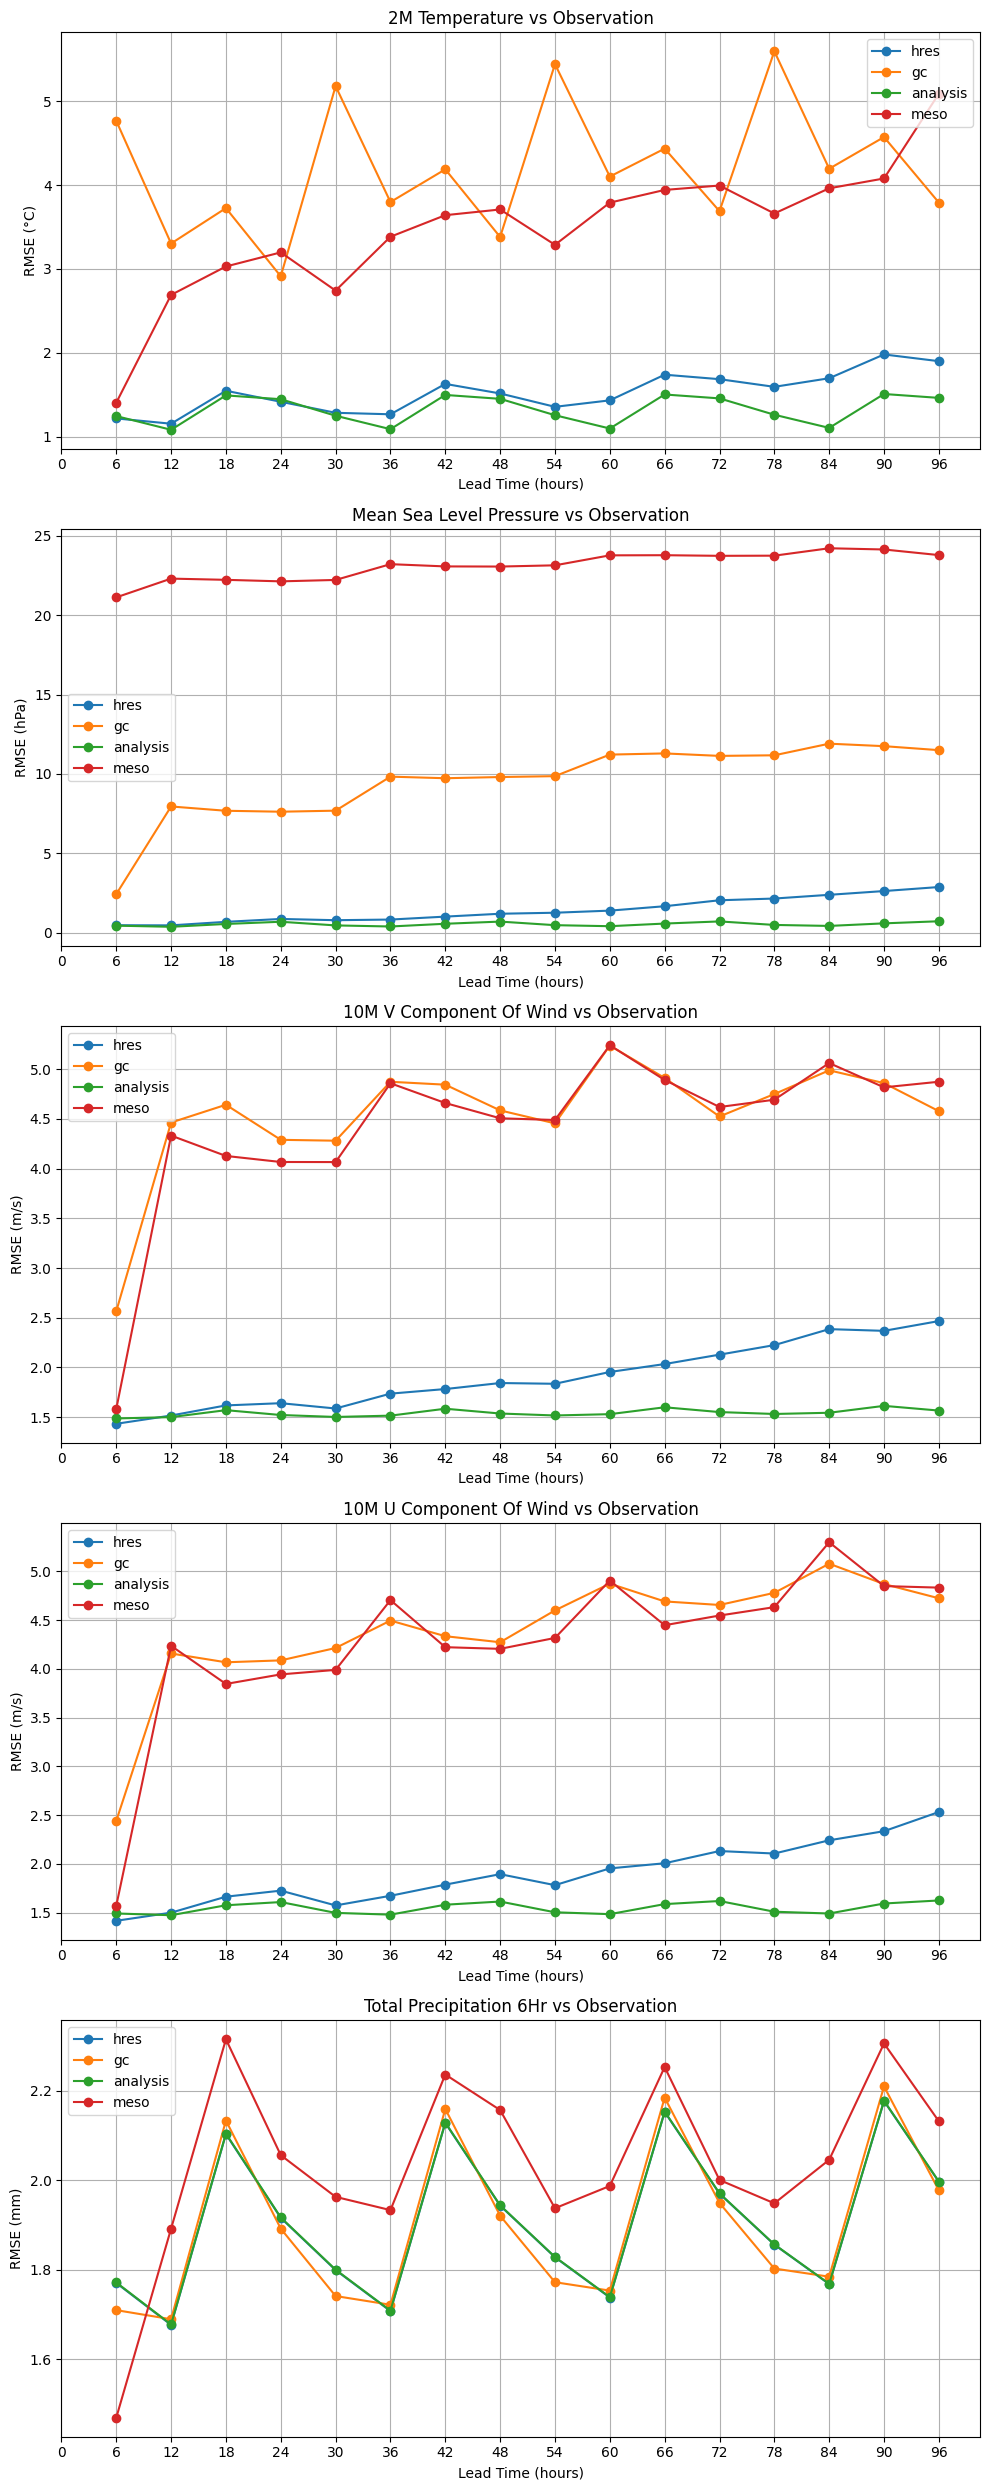

In [101]:
plot_statistic_results_comparison('rmse', rmse_hres, rmse_gc, rmse_analysis, rmse_meso)

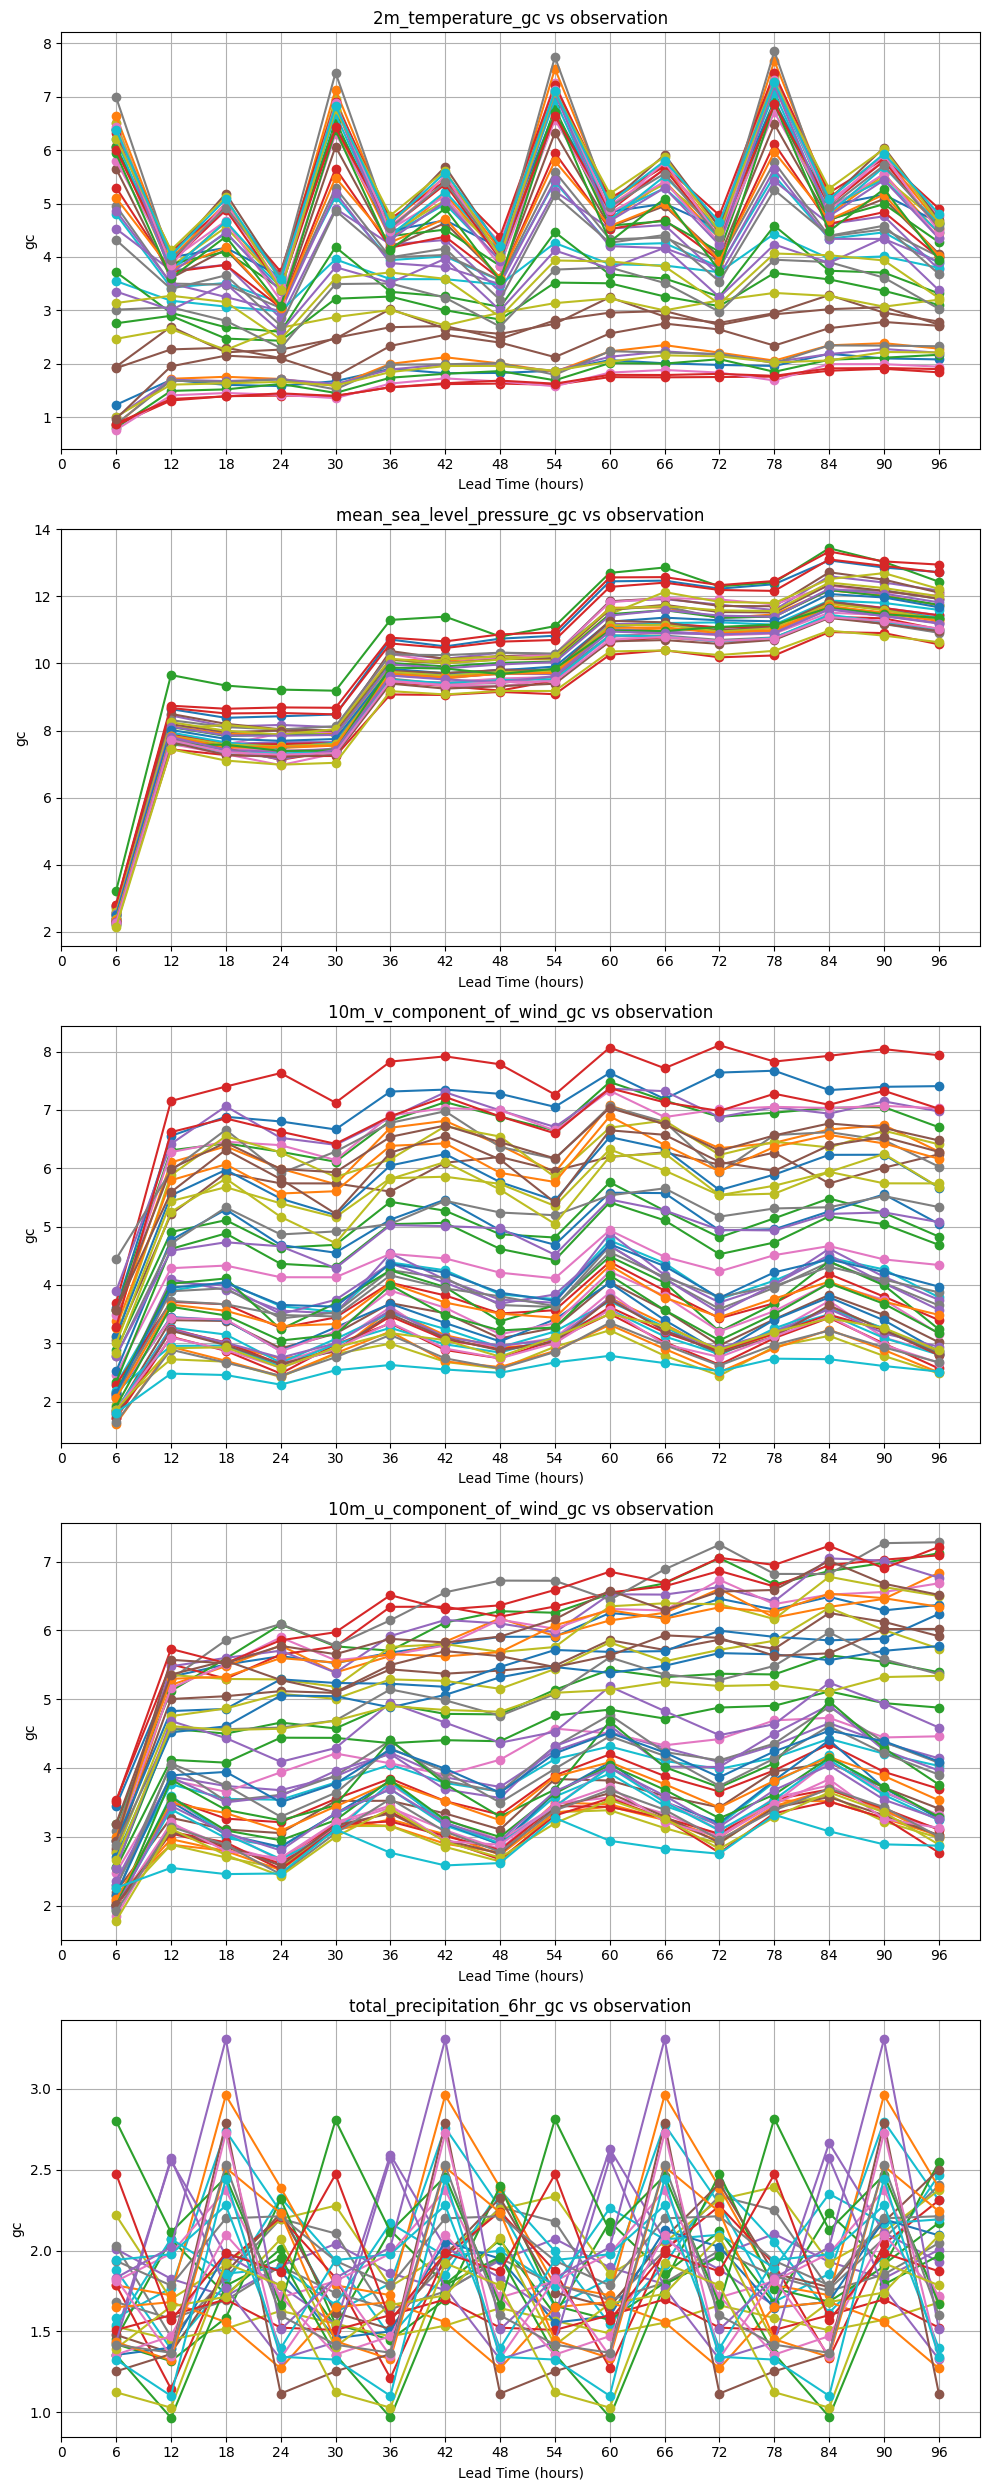

In [225]:
plot_statistic_results(rmse_gc)